In [1]:
!pip install counter
!pip install emoji
!pip install textblob
!pip install spacy
!python -m spacy download en

  Created wheel for counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=3f04c94e3b4714ac05ce0e466c0cb83209582b0373e8b179dfb9bc8b74b4aa16
  Stored in directory: /root/.cache/pip/wheels/f9/15/75/7a0462a00beb08e391f5da370ca409b56781d2501dba083fa3
Successfully built counter
     |████████████████████████████████| 168 kB 16.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=45e1ae7937ce99323f99a0ff9b6263a28db58ee6af28e731d7f6dc3bc33aa657
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji
     |████████████████████████████████| 12.0 MB 15.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
#Import Models 
import re, string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import emoji

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

#expanding the dispay of text sms column
pd.set_option('display.max_colwidth', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read Train data
train = pd.read_csv(open('/content/drive/MyDrive/ClimateChange/train.csv'))

In [5]:
# Read Test data
test = pd.read_csv(open("/content/drive/My Drive/ClimateChange/test.csv"))

In [6]:
train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [7]:
# Sentiment Dictionery mapping Crete a new column with Sentiment Class Map 
sentiment_dict = {-1:'anti', 0:'neutral', 1:'pro', 2:'news' }
train['class_desc'] = train['sentiment'].apply(lambda x: sentiment_dict.get(x))

In [8]:
train.shape

(15819, 4)

In [9]:
train.isnull().sum()

sentiment     0
message       0
tweetid       0
class_desc    0
dtype: int64

In [10]:
# Append Tarin and Test Data into single dataframe for preprocessing
train_test= train.append(test, ignore_index=True)

pro        8530
news       3640
neutral    2353
anti       1296
Name: class_desc, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


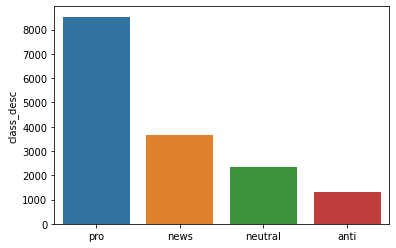

In [11]:
# CLASS DISTRIBUTION
#check if calls is balanced or not
x=train['class_desc'].value_counts()
print(x)
sns.barplot(x.index,x)

In [12]:
train_test.shape

(26365, 4)

In [13]:
train_test.head()

,sentiment,message,tweetid,class_desc
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,pro
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,pro
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,news
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,pro
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,pro


In [14]:
train_test.tail()

,sentiment,message,tweetid,class_desc
26360,NaN,"RT @BrittanyBohrer: Brb, writing a poem about climate change. #climatechange #science #poetry #fakenews #alternativefacts https://t.co/RpUs…",895714,NaN
26361,NaN,"2016: the year climate change came home: During the hottest year on record, Karl Mathiesen travelled to Tasmania… https://t.co/WwSrJQfvMg",875167,NaN
26362,NaN,RT @loop_vanuatu: Pacific countries positive about Fiji leading the global climate change conference in November. https://t.co/PIPRndhkYd,78329,NaN
26363,NaN,"RT @xanria_00018: You’re so hot, you must be the cause for global warming. #ALDUBLaborOfLove @jophie30 @asn585",867455,NaN
26364,NaN,RT @chloebalaoing: climate change is a global issue that's only getting worse. eating plant based is the least amount of effort that h…,470892,NaN


In [15]:
#Funtion used to check if data is text
def fun_is_not_alpha(df):
  df_join = df.apply(lambda x: ' '.join(x))
  all_words = [text for text in df_join if not text.isalpha()]
  return all_words

In [16]:
#Funtion to remove URL's in data
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

#Funtion to remove any html in text
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

#Function to remove any punctuations in text
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


train_test['text_clean'] = train_test['message'].apply(lambda x: remove_URL(x))
train_test['text_clean'] = train_test['text_clean'].apply(lambda x: remove_html(x))
train_test['text_clean'] = train_test['text_clean'].apply(lambda x: remove_punct(x))

In [17]:
#Replace re-tweet tag in text.
train_test['clean_tweet'] = train_test['text_clean'].apply(lambda x: re.sub(r'^RT[\s]+', ' ', x))

In [18]:
#Convert emoji to text
train_test['emoji_out'] = train_test['clean_tweet'].apply(lambda x: emoji.demojize(x, delimiters=("", "")))

In [19]:
#Remove - and replce with space
train_test['cleaned_tweet'] = train_test['emoji_out'].apply(lambda x: re.sub(r'-', ' ', x))

In [20]:
# Remove _ and replace with space
train_test['cleaned_tweet'] = train_test['cleaned_tweet'].apply(lambda x: re.sub(r'_', ' ', x))

In [21]:
train_test.head()

,sentiment,message,tweetid,class_desc,text_clean,clean_tweet,emoji_out,cleaned_tweet
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,pro,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,pro,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,news,RT RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,pro,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,pro,RT SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight


In [22]:
#Import Spacy English and create word tokens
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

train_test['tokens'] = train_test['cleaned_tweet'].apply(lambda x: [str(x) for x in nlp(x)])

In [23]:
#Lower text case
train_test['tweet'] = train_test['tokens'].apply(lambda x: [w.lower() for w in x])

In [24]:
#Create a text drop list and drop if found in tokens
drop_text = ['http','https','htt','\n','eg','\n\n']
train_test['tweet'] = train_test['tweet'].apply(lambda x: [w for w in x if w not in drop_text])

In [25]:
#Strip digits from word tokens
train_test['c_tweet'] = train_test['tweet'].apply(lambda x: [re.sub('W*dw*','',w) for w in x])

In [26]:
#Drop Digit Tokens
train_test['c_tweet'] = train_test['c_tweet'].apply(lambda x: [re.sub('[0-9]+', '', w) for w in x])

In [27]:
#Remove all characters in a string except alphabets
train_test['c_tweet'] = train_test['c_tweet'].apply(lambda x: [re.sub('[^a-zA-Z]+', '', w) for w in x])

In [28]:
#Remove spaces at the beginning and at the end of the string
train_test['c_tweet'] = train_test['c_tweet'].apply(lambda x: [w.strip() for w in x])

In [29]:
#Create a text drop list and drop if found in tokens
drop_text = ['http','https','htt','\n','eg','\n\n']
train_test['c_tweet'] = train_test['c_tweet'].apply(lambda x: [w for w in x if w not in drop_text])

In [30]:
#Check text is not alpha
fun_is_not_alpha(train_test['c_tweet'])

['polyscimajor epa chief oes nt think carbon ioxie is main cause of global warming an wait what  via mashable',
 'its not like we lack evience of anthropogenic global warming',
 ' rawstory researchers say we have three years to act on climate change before it s too late ',
 'toayinmaker wire   was a pivotal year in the war on climate change',
 ' soynovioetoas its  an a racist sexist climate change enying bigot is leaing in the polls electionnight',
 'worth a rea whether you o or o nt believe in climate change ',
 ' thenation mike pence oes nt believe in global warming or that smoking causes lung cancer',
 ' makeanmenlife six big things we can all o toay to fight climate change or how to be a climate activist   h ',
 'aceofspaeshq my yo nephew is inconsolable he wants to ie of ol age like me but will perish in the fiery hellscape of climate change',
 ' paigetweey no offense  but like  how o you just not believe  in global warming  ',
 ' stephenschlegel she s thinking about how she s goi

In [31]:
train_test.head()

,sentiment,message,tweetid,class_desc,text_clean,clean_tweet,emoji_out,cleaned_tweet,tokens,tweet,c_tweet
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,pro,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what via mashable,"[PolySciMajor, EPA, chief, does, nt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, , via, mashable]","[polyscimajor, epa, chief, does, nt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, , via, mashable]","[polyscimajor, epa, chief, oes, nt, think, carbon, ioxie, is, main, cause, of, global, warming, an, wait, what, , via, mashable]"
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,pro,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,Its not like we lack evidence of anthropogenic global warming,"[Its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[its, not, like, we, lack, evience, of, anthropogenic, global, warming]"
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,news,RT RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late,RawStory Researchers say we have three years to act on climate change before it’s too late,"[ , RawStory, Researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’s, too, late, ]","[ , rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’s, too, late, ]","[, rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, s, too, late, ]"
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,pro,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,TodayinMaker WIRED 2016 was a pivotal year in the war on climate change,"[TodayinMaker, WIRED, , 2016, was, a, pivotal, year, in, the, war, on, climate, change]","[todayinmaker, wired, , 2016, was, a, pivotal, year, in, the, war, on, climate, change]","[toayinmaker, wire, , , was, a, pivotal, year, in, the, war, on, climate, change]"
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,pro,RT SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls ElectionNight,"[ , SoyNovioDeTodas, Its, 2016, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, ElectionNight]","[ , soynoviodetodas, its, 2016, and, a, racist, sexist, climate, cha

In [ ]:
#Import Spacy Stops and remove all stop words in text
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

train_test['x_stopwords'] = train_test['tokens'].apply(lambda x: [word for word in x if word not in en_stop])

In [ ]:
#Remove any text token less than < 1 char
train_test['clean_tokens_2'] = train_test['clean_tokens_2'].apply(lambda x: [w for w in x if len(w) > 1])

In [32]:
#Join token into text string
train_test['ml_text'] = train_test['c_tweet'].apply(lambda x: ' '.join(x))

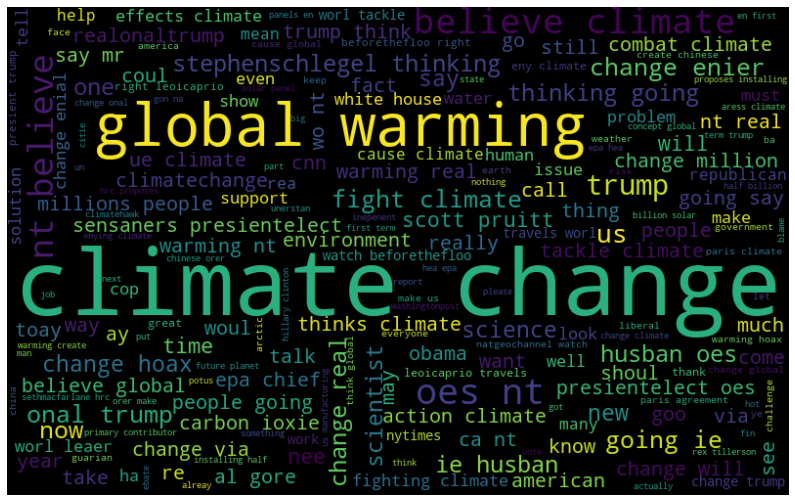

In [33]:
#Create a text word cloud
all_words = ' '.join([text for text in train_test['ml_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [34]:
train_test.columns

Index(['sentiment', 'message', 'tweetid', 'class_desc', 'text_clean',
       'clean_tweet', 'emoji_out', 'cleaned_tweet', 'tokens', 'tweet',
       'c_tweet', 'ml_text'],
      dtype='object')

In [35]:
#Drop Columns
train_test_drop = train_test.drop(columns=['sentiment', 'message', 'text_clean',
       'clean_tweet', 'emoji_out', 'cleaned_tweet', 'tokens', 'tweet',
       'c_tweet'])

In [36]:
train_test_drop.tail(10)

,tweetid,class_desc,ml_text
26355,288271,NaN,sensaners scientists isagree in means of imension not in means of origin of global warming an climate change as such
26356,961513,NaN,a scientists explain apocalyptic effect of trump pulling out of the paris climate change agreement
26357,46205,NaN,just watche nat geos ocumentary about climate change beforethefloo feethemin beinforme
26358,27319,NaN,kazahann this will be their pretext for iran us navy emphasize that climate change poses a threat to national security
26359,634943,NaN,sciencenews what s the cost of climate change for your county
26360,895714,NaN,brittanybohrer brb writing a poem about climate change climatechange science poetry fakenews alternativefacts
26361,875167,NaN,the year climate change came home uring the hottest year on recor karl mathiesen travelle to tasmania
26362,78329,NaN,loopvanuatu pacific countries positive about fiji leaing the global climate change conference in november
26363,867455,NaN,xanria you re so hot you must be the cause for global warming alublaboroflove jophie asn
26364,470892,NaN,chloebalaoing climate change is a global issue that s only getting worse eating plant base is the least amount of effort that h


In [37]:
#Use Counter to count words
from collections import Counter
word_count = pd.DataFrame.from_dict(Counter(all_words.split(' ')),orient='index', columns=['Count'])

In [38]:
word_count.sort_values('Count').tail(20)

,Count
you,2685
that,2810
about,2966
i,2988
for,3360
trump,3430
nt,3711
on,4661
warming,5874
an,5883


In [39]:
#Check word is not alphabets
is_not_alpha = [word for word in word_count.index if not word.isalpha()]

In [40]:
print(is_not_alpha)

['']


In [41]:
print(len(is_not_alpha))

1


In [42]:
train_test_drop.head()

,tweetid,class_desc,ml_text
0,625221,pro,polyscimajor epa chief oes nt think carbon ioxie is main cause of global warming an wait what via mashable
1,126103,pro,its not like we lack evience of anthropogenic global warming
2,698562,news,rawstory researchers say we have three years to act on climate change before it s too late
3,573736,pro,toayinmaker wire was a pivotal year in the war on climate change
4,466954,pro,soynovioetoas its an a racist sexist climate change enying bigot is leaing in the polls electionnight


In [43]:
#Split Dataframe into Train Dataframe
df_train = train_test_drop[:len(train)]

In [44]:
#Split Dataframe into Test Dataframe
df_test = train_test_drop[len(train):]

In [45]:
df_train.head()

,tweetid,class_desc,ml_text
0,625221,pro,polyscimajor epa chief oes nt think carbon ioxie is main cause of global warming an wait what via mashable
1,126103,pro,its not like we lack evience of anthropogenic global warming
2,698562,news,rawstory researchers say we have three years to act on climate change before it s too late
3,573736,pro,toayinmaker wire was a pivotal year in the war on climate change
4,466954,pro,soynovioetoas its an a racist sexist climate change enying bigot is leaing in the polls electionnight


In [46]:
#Remove Tweetid column form training dataframe
df_train = df_train.drop(columns=['tweetid'])

In [47]:
df_train.head()

,class_desc,ml_text
0,pro,polyscimajor epa chief oes nt think carbon ioxie is main cause of global warming an wait what via mashable
1,pro,its not like we lack evience of anthropogenic global warming
2,news,rawstory researchers say we have three years to act on climate change before it s too late
3,pro,toayinmaker wire was a pivotal year in the war on climate change
4,pro,soynovioetoas its an a racist sexist climate change enying bigot is leaing in the polls electionnight


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Use Tfidfvectorizer to compute the word counts, idf and tf-idf values
count_vect = TfidfVectorizer(ngram_range=(1,2),min_df=2)
X_train_counts = count_vect.fit_transform(df_train['ml_text'])

In [49]:
#Split Training data into training set and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train_counts,df_train['class_desc'], test_size=0.3, random_state = 11,shuffle=True,stratify=df_train['class_desc'])

In [50]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11073, 30174), (4746, 30174), (11073,), (4746,))

In [51]:
#Create a clas list for use
class_list = list(set(Y_train))
print(class_list)

['neutral', 'news', 'anti', 'pro']


In [52]:
#Import Package for ML modeling 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier

#Create list of ML models
models = [
    LinearSVC(),
    RidgeClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(multi_class='multinomial',max_iter=1000,random_state=0),
    MultinomialNB()
]

#Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, Y_train, scoring='f1_macro',cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

#Dataframe with Models and F1 Score 
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [55]:
#Print Model list with Mean and Standard Deviation F1 Score
mean_F1_Score = cv_df.groupby('model_name').accuracy.mean()
std_F1_Score = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_F1_Score, std_F1_Score], axis= 1, 
          ignore_index=True)
acc.columns = ['F1_Score_Mean', 'F1_Score_Standard']
acc

,F1_Score_Mean,F1_Score_Standard
model_name,,
GradientBoostingClassifier,0.524192,0.019851
LinearSVC,0.642450,0.010143
LogisticRegression,0.568698,0.010554
MultinomialNB,0.399158,0.010301
RidgeClassifier,0.629948,0.012769


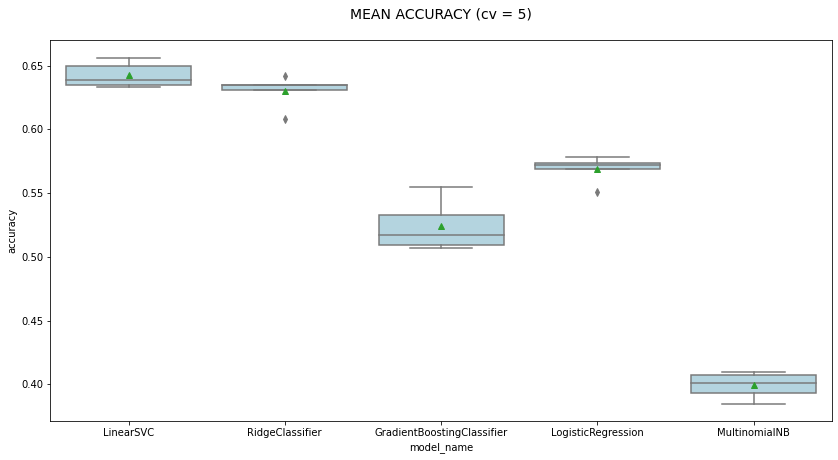

In [58]:
#Plot Graph to compare models
plt.figure(figsize=(14,7))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
#Grid Search and Cross Validate LinearSVC Model
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# defining parameter range
space = dict()
space['C'] = [0.1, 0.5, 0.8]
space['loss'] = ['hinge', 'squared_hinge']
space['class_weight'] = ['dict','balanced','None']

linsvc_model = LinearSVC()
 
grid = GridSearchCV(linsvc_model, space, refit= True, cv=CV, scoring='f1_macro',n_jobs=-1)

# fitting the model for grid search
grid.fit(X_train, Y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_

y_pred = best_model.predict(X_test)


print('accuracy %s' % accuracy_score(Y_test, y_pred))
print('f_1 %s' % f1_score(Y_test, y_pred, average="macro"))
print(classification_report(Y_test, y_pred,target_names=class_list))
#Get the confusion matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix:',cf_matrix)

accuracy 0.7425200168563001
f_1 0.6609786232698444
              precision    recall  f1-score   support

        anti       0.64      0.47      0.54       389
        news       0.55      0.48      0.51       706
     neutral       0.74      0.82      0.78      1092
         pro       0.80      0.82      0.81      2559

    accuracy                           0.74      4746
   macro avg       0.68      0.65      0.66      4746
weighted avg       0.74      0.74      0.74      4746

Confusion Matrix: [[ 183   74   20  112]
 [  34  336   72  264]
 [   8   30  896  158]
 [  59  174  217 2109]]


In [ ]:
print(best_model)

LinearSVC(C=0.8, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
#RidgeClassifier Model with OneVsOneClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier

# define models and parameters
ridge_model = OneVsOneClassifier(RidgeClassifier())

ridge_m = ridge_model.fit(X_train, Y_train)

y_pred = ridge_m.predict(X_test)

f1_score(Y_test, y_pred, average="macro")

print('accuracy %s' % accuracy_score(Y_test, y_pred))
print('f_1 %s' % f1_score(Y_test, y_pred, average="macro"))
print(classification_report(Y_test, y_pred,target_names=class_list))
#Get the confusion matrix
cf_matrix_ridge = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix:',cf_matrix_ridge)

accuracy 0.7448377581120944
f_1 0.624115809158398
              precision    recall  f1-score   support

        anti       0.85      0.29      0.44       389
        news       0.65      0.37      0.47       706
     neutral       0.79      0.75      0.77      1092
         pro       0.74      0.91      0.82      2559

    accuracy                           0.74      4746
   macro avg       0.76      0.58      0.62      4746
weighted avg       0.75      0.74      0.72      4746

Confusion Matrix: [[ 114   58   19  198]
 [  11  264   50  381]
 [   1   18  816  257]
 [   8   66  144 2341]]


In [ ]:
df_test.head()

,tweetid,class_desc,ml_text,sentiment_dict,sentiment
15819,169760,NaN,europe will now be looking to china to make sure that it is not alone in fighting climate change,pro,1
15820,35326,NaN,combine this with the polling of staffers re climate change and womens rights and you have fascist state,pro,1
15821,224985,NaN,the scary unimpeachable evidence that climate change is already here itstimetochange climatechange zeroco,pro,1
15822,476263,NaN,karoli morgfair osborneink dailykos putin got to you too jill trump doesn t believe in climate change at all thinks it s hoax,pro,1
15823,872928,NaN,fakewillmoore female orgasms cause global warming sarcastic republican,neutral,0


In [ ]:
# function to return key for any value
def get_key(val):
    for key, value in sentiment_dict.items():
         if val == value:
             return key

In [ ]:
#Testing it on new dataset with the best model
X_test = df_test['ml_text'] 
X_vector=count_vect.transform(X_test) #converting X_test to vector
y_pred = best_model.predict(X_vector) #use the trained model on X_vector
df_test['sentiment_dict'] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test['sentiment'] = df_test['sentiment_dict'].apply(lambda x: get_key(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test[['tweetid','sentiment']].to_csv('/content/drive/My Drive/climate_change_2.csv', index=False)